In [14]:
# Cropping the images according to the bounding boxes in order to create a dataset of images with equal dimensions and size.

from PIL import Image
import numpy as np

def resize_image(image_name):
    # image_path =  os.path.join(DATA_DIR, image_name)
    im = Image.open(image_name)
    width,height = im.size

    new_width = min(width,height)
    new_height = min(width,height)

    left = int(np.ceil((width - new_width)/2))
    top = int(np.ceil((height - new_height)/2))
    right = int(np.ceil((width + new_width)/2))
    bottom = int(np.ceil((height + new_height)/2))

    im = im.crop((left, top, right, bottom))
    # im.save(os.path.join(OUTPUT_DIR, image_name))
    return im

im = Image.open("1.jpg")
im.show()
gen_im = resize_image(image_name="1.jpg")
gen_im.show()


KeyboardInterrupt: 

RuntimeError: Expected one of cpu, cuda, xpu, mkldnn, opengl, opencl, ideep, hip, ve, ort, mlc, xla, lazy, vulkan, meta, hpu device type at start of device string: gpu

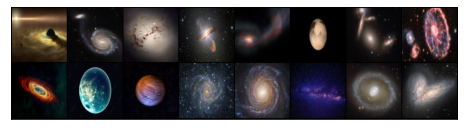

In [15]:
# Taking the image as input and generating a new image raw image.

import os
import torch
import torchvision
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image

DATA_DIR = "./data/"

stats = (.5, .5, .5), (.5, .5, .5)

transform_ds = T.Compose([
    T.Resize((128, 128)),
    T.CenterCrop(128),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.ToTensor(),
    T.Normalize(*stats)
])
ds = torchvision.datasets.ImageFolder(root=DATA_DIR, transform=transform_ds)


def denorm(img_tensor):
    return img_tensor * stats[1][0] + stats[0][0]


batch_size = 16

train_dl = DataLoader(ds, batch_size, shuffle=True,
                      num_workers=3, pin_memory=True)


def show_image(train_dl):
    for images, _ in train_dl:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(
            make_grid(denorm(images.detach()[:32]), nrow=8).permute(1, 2, 0))
        break


show_image(train_dl)


def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")


def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)


device = get_device()

train_dl = DeviceDataLoader(train_dl, device)

discriminator = nn.Sequential(
    #in: 128 x 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 512 x 8 x 8

    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #128 x 1024 x 4 x 4

    nn.Conv2d(1024, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #128 x 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

discriminator = to_device(discriminator, device)

latent_size = 128
generator = nn.Sequential(
    #in: 128 x 1 x 1

    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4,
                       stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #128 x 1024 x 4 x 4

    nn.ConvTranspose2d(1024, 512, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #128 x 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #128 x 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #128 x 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4,
                       stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #128 x 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #128 x 3 x 128 x 128
    nn.Tanh()


)


generator = to_device(generator, device)


def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward(),
    opt_d.step()

    return loss.item(), real_score, fake_score


def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(latent_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(fake_images.size(0), 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward(),
    opt_g.step()

    return loss.item()


sample_dir = "generated"
os.makedirs(sample_dir, exist_ok=True)


def save_sample(index, fixed_latent, show=True):
    fake_images = generator(fixed_latent)
    fake_fname = "generated-images-{0:0=4d}.png".format(index)
    save_image(denorm(fake_images), os.path.join(
        sample_dir, fake_fname), nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach()
                  [:32], nrow=8).permute(1, 2, 0))


fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)
save_sample(0, fixed_latent, show=True)


def fit(epochs, lr_d, lr_g, start_idx=1):
    torch.cuda.empty_cache()

    losses_d = []
    losses_g = []
    real_scores = []
    fake_scores = []

    opt_d = torch.optim.Adam(discriminator.parameters(),
                             lr=lr_d, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(),
                             lr=lr_g, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(
                real_images, opt_d)
            loss_g = train_generator(opt_g)

        losses_d.append(loss_d)
        losses_g.append(loss_g)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch: [{}/{}], loss_d: {:.4f}, loss_g: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_d, loss_g, real_score, fake_score))

        save_sample(epoch+start_idx, fixed_latent, show=False)

    return losses_d, losses_g, real_scores, fake_scores


epochs = 50
lr_d = 10e-5
lr_g = 10e-4

history = [fit(epochs, lr_d, lr_g, start_idx=1)]

In [ ]:
# # example of progressive growing gan on celebrity faces dataset
# from math import sqrt
# from numpy import load
# from numpy import asarray
# from numpy import zeros
# from numpy import ones
# from numpy.random import randn
# from numpy.random import randint
# from skimage.transform import resize
# from keras.optimizers import Adam
# from keras.models import Sequential
# from keras.models import Model
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Reshape
# from keras.layers import Conv2D
# from keras.layers import UpSampling2D
# from keras.layers import AveragePooling2D
# from keras.layers import LeakyReLU
# from keras.layers import Layer
# from keras.layers import Add
# from keras.constraints import max_norm
# from keras.initializers import RandomNormal
# from keras import backend
# from matplotlib import pyplot

# # pixel-wise feature vector normalization layer
# class PixelNormalization(Layer):
# # initialize the layer
#     def __init__(self, **kwargs):
#         super(PixelNormalization, self).__init__(**kwargs)

# # perform the operation
# def call(self, inputs):
#     # calculate square pixel values
#     values = inputs**2.0
#     # calculate the mean pixel values
#     mean_values = backend.mean(values, axis=-1, keepdims=True)
#     # ensure the mean is not zero
#     mean_values += 1.0e-8
#     # calculate the sqrt of the mean squared value (L2 norm)
#     l2 = backend.sqrt(mean_values)
#     # normalize values by the l2 norm
#     normalized = inputs / l2
#     return normalized

# # define the output shape of the layer
# def compute_output_shape(self, input_shape):
#     return input_shape

# # mini-batch standard deviation layer
# class MinibatchStdev(Layer):
#     # initialize the layer
#     def __init__(self, **kwargs):
#         super(MinibatchStdev, self).__init__(**kwargs)

#     # perform the operation
#     def call(self, inputs):
#         # calculate the mean value for each pixel across channels
#         mean = backend.mean(inputs, axis=0, keepdims=True)
#         # calculate the squared differences between pixel values and mean
#         squ_diffs = backend.square(inputs - mean)
#         # calculate the average of the squared differences (variance)
#         mean_sq_diff = backend.mean(squ_diffs, axis=0, keepdims=True)
#         # add a small value to avoid a blow-up when we calculate stdev
#         mean_sq_diff += 1e-8
#         # square root of the variance (stdev)
#         stdev = backend.sqrt(mean_sq_diff)
#         # calculate the mean standard deviation across each pixel coord
#         mean_pix = backend.mean(stdev, keepdims=True)
#         # scale this up to be the size of one input feature map for each sample
#         shape = backend.shape(inputs)
#         output = backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
#         # concatenate with the output
#         combined = backend.concatenate([inputs, output], axis=-1)
#         return combined

#     # define the output shape of the layer
#     def compute_output_shape(self, input_shape):
#         # create a copy of the input shape as a list
#         input_shape = list(input_shape)
#         # add one to the channel dimension (assume channels-last)
#         input_shape[-1] += 1
#         # convert list to a tuple
#         return tuple(input_shape)

# # weighted sum output
# class WeightedSum(Add):
#     # init with default value
#     def __init__(self, alpha=0.0, **kwargs):
#         super(WeightedSum, self).__init__(**kwargs)
#         self.alpha = backend.variable(alpha, name='ws_alpha')

#     # output a weighted sum of inputs
#     def _merge_function(self, inputs):
#         # only supports a weighted sum of two inputs
#         assert (len(inputs) == 2)
#         # ((1-a) * input1) + (a * input2)
#         output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
#         return output

#     # calculate wasserstein loss
#     def wasserstein_loss(y_true, y_pred):
#         return backend.mean(y_true * y_pred)

#     # add a discriminator block
#     def add_discriminator_block(old_model, n_input_layers=3):
#         # weight initialization
#         init = RandomNormal(stddev=0.02)
#         # weight constraint
#         const = max_norm(1.0)
#         # get shape of existing model
#         in_shape = list(old_model.input.shape)
#         # define new input shape as double the size
#         input_shape = (in_shape[-2].value*2, in_shape[-2].value*2, in_shape[-1].value)
#         in_image = Input(shape=input_shape)
#         # define new input processing layer
#         d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
#         d = LeakyReLU(alpha=0.2)(d)
#         # define new block
#         d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
#         d = LeakyReLU(alpha=0.2)(d)
#         d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
#         d = LeakyReLU(alpha=0.2)(d)
#         d = AveragePooling2D()(d)
#         block_new = d
#         # skip the input, 1x1 and activation for the old model
#         for i in range(n_input_layers, len(old_model.layers)):
#             d = old_model.layers[i](d)
#             # define straight-through model
#             model1 = Model(in_image, d)
#             # compile model
#             model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
#             # downsample the new larger image
#             downsample = AveragePooling2D()(in_image)
#             # connect old input processing to downsampled new input
#             block_old = old_model.layers[1](downsample)
#             block_old = old_model.layers[2](block_old)
#             # fade in output of old model input layer with new input
#             d = WeightedSum()([block_old, block_new])
#         # skip the input, 1x1 and activation for the old model
#         for i in range(n_input_layers, len(old_model.layers)):
#             d = old_model.layers[i](d)
#             # define straight-through model
#             model2 = Model(in_image, d)
#             # compile model
#             model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
#             return [model1, model2]

#     # define the discriminator models for each image resolution
#     def define_discriminator(n_blocks, input_shape=(4,4,3)):
#         # weight initialization
#         init = RandomNormal(stddev=0.02)
#         # weight constraint
#         const = max_norm(1.0)
#         model_list = list()
#         # base model input
#         in_image = Input(shape=input_shape)
#         # conv 1x1
#         d = Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
#         d = LeakyReLU(alpha=0.2)(d)
#         # conv 3x3 (output block)
#         d = MinibatchStdev()(d)
#         d = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
#         d = LeakyReLU(alpha=0.2)(d)
#         # conv 4x4
#         d = Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
#         d = LeakyReLU(alpha=0.2)(d)
#         # dense output layer
#         d = Flatten()(d)
#         out_class = Dense(1)(d)
#         # define model
#         model = Model(in_image, out_class)
#         # compile model
#         model.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
#         # store model
#         model_list.append([model, model])
#         # create submodels
#         for i in range(1, n_blocks):
#             # get prior model without the fade-on
#             old_model = model_list[i - 1][0]
#             # create new model for next resolution
#             models = add_discriminator_block(old_model)
#             # store model
#             model_list.append(models)
#             return model_list

#     # add a generator block
#     def add_generator_block(old_model):
#         # weight initialization
#         init = RandomNormal(stddev=0.02)
#         # weight constraint
#         const = max_norm(1.0)
#         # get the end of the last block
#         block_end = old_model.layers[-2].output
#         # upsample, and define new block
#         upsampling = UpSampling2D()(block_end)
#         g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
#         g = PixelNormalization()(g)
#         g = LeakyReLU(alpha=0.2)(g)
#         g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
#         g = PixelNormalization()(g)
#         g = LeakyReLU(alpha=0.2)(g)
#         # add new output layer
#         out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
#         # define model
#         model1 = Model(old_model.input, out_image)
#         # get the output layer from old model
#         out_old = old_model.layers[-1]
#         # connect the upsampling to the old output layer
#         out_image2 = out_old(upsampling)
#         # define new output image as the weighted sum of the old and new models
#         merged = WeightedSum()([out_image2, out_image])
#         # define model
#         model2 = Model(old_model.input, merged)
#         return [model1, model2]

#     # define generator models
#     def define_generator(latent_dim, n_blocks, in_dim=4):
#         # weight initialization
#         init = RandomNormal(stddev=0.02)
#         # weight constraint
#         const = max_norm(1.0)
#         model_list = list()
#         # base model latent input
#         in_latent = Input(shape=(latent_dim,))
#         # linear scale up to activation maps
#         g  = Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
#         g = Reshape((in_dim, in_dim, 128))(g)
#         # conv 4x4, input block
#         g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
#         g = PixelNormalization()(g)
#         g = LeakyReLU(alpha=0.2)(g)
#         # conv 3x3
#         g = Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
#         g = PixelNormalization()(g)
#         g = LeakyReLU(alpha=0.2)(g)
#         # conv 1x1, output block
#         out_image = Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
#         # define model
#         model = Model(in_latent, out_image)
#         # store model
#         model_list.append([model, model])
#         # create submodels
#         for i in range(1, n_blocks):
#             # get prior model without the fade-on
#             old_model = model_list[i - 1][0]
#             # create new model for next resolution
#             models = add_generator_block(old_model)
#             # store model
#             model_list.append(models)
#             return model_list

#     # define composite models for training generators via discriminators
#     def define_composite(discriminators, generators):
#         model_list = list()
#         # create composite models
#         for i in range(len(discriminators)):
#             g_models, d_models = generators[i], discriminators[i]
#             # straight-through model
#             d_models[0].trainable = False
#             model1 = Sequential()
#             model1.add(g_models[0])
#             model1.add(d_models[0])
#             model1.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
#             # fade-in model
#             d_models[1].trainable = False
#             model2 = Sequential()
#             model2.add(g_models[1])
#             model2.add(d_models[1])
#             model2.compile(loss=wasserstein_loss, optimizer=Adam(lr=0.001, beta_1=0, beta_2=0.99, epsilon=10e-8))
#             # store
#             model_list.append([model1, model2])
#             return model_list

#     # load dataset
#     def load_real_samples(filename):
#         # load dataset
#         data = load(filename)
#         # extract numpy array
#         X = data['arr_0']
#         # convert from ints to floats
#         X = X.astype('float32')
#         # scale from [0,255] to [-1,1]
#         X = (X - 127.5) / 127.5
#         return X

# # select real samples
#     def generate_real_samples(dataset, n_samples):
#         # choose random instances
#         ix = randint(0, dataset.shape[0], n_samples)
#         # select images
#         X = dataset[ix]
#         # generate class labels
#         y = ones((n_samples, 1))
#         return X, y

# # generate points in latent space as input for the generator
#     def generate_latent_points(latent_dim, n_samples):
#         # generate points in the latent space
#         x_input = randn(latent_dim * n_samples)
#         # reshape into a batch of inputs for the network
#         x_input = x_input.reshape(n_samples, latent_dim)
#         return x_input

#     # use the generator to generate n fake examples, with class labels
#     def generate_fake_samples(generator, latent_dim, n_samples):
#         # generate points in latent space
#         x_input = generate_latent_points(latent_dim, n_samples)
#         # predict outputs
#         X = generator.predict(x_input)
#         # create class labels
#         y = -ones((n_samples, 1))
#         return X, y

# # update the alpha value on each instance of WeightedSum
#     def update_fadein(models, step, n_steps):
#         # calculate current alpha (linear from 0 to 1)
#         alpha = step / float(n_steps - 1)
#         # update the alpha for each model
#         for model in models:
#             for layer in model.layers:
#                 if isinstance(layer, WeightedSum):
#                     backend.set_value(layer.alpha, alpha)

#         # train a generator and discriminator
#     def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, fadein=False):
#         # calculate the number of batches per training epoch
#         bat_per_epo = int(dataset.shape[0] / n_batch)
#         # calculate the number of training iterations
#         n_steps = bat_per_epo * n_epochs
#         # calculate the size of half a batch of samples
#         half_batch = int(n_batch / 2)
#         # manually enumerate epochs
#         for i in range(n_steps):
#             # update alpha for all WeightedSum layers when fading in new blocks
#             if fadein:
#                 update_fadein([g_model, d_model, gan_model], i, n_steps)
#                 # prepare real and fake samples
#                 X_real, y_real = generate_real_samples(dataset, half_batch)
#                 X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
#                 # update discriminator model
#                 d_loss1 = d_model.train_on_batch(X_real, y_real)
#                 d_loss2 = d_model.train_on_batch(X_fake, y_fake)
#                 # update the generator via the discriminator's error
#                 z_input = generate_latent_points(latent_dim, n_batch)
#                 y_real2 = ones((n_batch, 1))
#                 g_loss = gan_model.train_on_batch(z_input, y_real2)
#                 # summarize loss on this batch
#                 print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))

# # scale images to preferred size
#     def scale_dataset(images, new_shape):
#         images_list = list()
#         for image in images:
#             # resize with nearest neighbor interpolation
#             new_image = resize(image, new_shape, 0)
#             # store
#             images_list.append(new_image)
#             return asarray(images_list)

#     # generate samples and save as a plot and save the model
#     def summarize_performance(status, g_model, latent_dim, n_samples=25):
#         # devise name
#         gen_shape = g_model.output_shape
#         name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
#         # generate images
#         X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
#         # normalize pixel values to the range [0,1]
#         X = (X - X.min()) / (X.max() - X.min())
#         # plot real images
#         square = int(sqrt(n_samples))
#         for i in range(n_samples):
#             pyplot.subplot(square, square, 1 + i)
#             pyplot.axis('off')
#             pyplot.imshow(X[i])
#             # save plot to file
#             filename1 = 'plot_%s.png' % (name)
#             pyplot.savefig(filename1)
#             pyplot.close()
#             # save the generator model
#             filename2 = 'model_%s.h5' % (name)
#             g_model.save(filename2)
#             print('>Saved: %s and %s' % (filename1, filename2))

# # train the generator and discriminator
#     def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
#         # fit the baseline model
#         g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
#         # scale dataset to appropriate size
#         gen_shape = g_normal.output_shape
#         scaled_data = scale_dataset(dataset, gen_shape[1:])
#         print('Scaled Data', scaled_data.shape)
#         # train normal or straight-through models
#         train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0])
#         summarize_performance('tuned', g_normal, latent_dim)
#         # process each level of growth
#         for i in range(1, len(g_models)):
#             # retrieve models for this level of growth
#             [g_normal, g_fadein] = g_models[i]
#             [d_normal, d_fadein] = d_models[i]
#             [gan_normal, gan_fadein] = gan_models[i]
#             # scale dataset to appropriate size
#             gen_shape = g_normal.output_shape
#             scaled_data = scale_dataset(dataset, gen_shape[1:])
#             print('Scaled Data', scaled_data.shape)
#             # train fade-in models for next level of growth
#             train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i], True)
#             summarize_performance('faded', g_fadein, latent_dim)
#             # train normal or straight-through models
#             train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i])
#             summarize_performance('tuned', g_normal, latent_dim)


# # number of growth phases, e.g. 6 == [4, 8, 16, 32, 64, 128]
# n_blocks = 6
# # size of the latent space
# latent_dim = 100
# # define models
# d_models = define_discriminator(n_blocks)
# # define models
# g_models = define_generator(latent_dim, n_blocks)
# # define composite models
# gan_models = define_composite(d_models, g_models)
# # load image data
# dataset = load_real_samples('img_align_celeba_128.npz')
# print('Loaded', dataset.shape)
# # train model
# n_batch = [16, 16, 16, 8, 4, 4]
# # 10 epochs == 500K images per training phase
# n_epochs = [5, 8, 8, 10, 10, 10]
# train(g_models, d_models, gan_models, dataset, latent_dim, n_epochs, n_epochs, n_batch)